In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.utils as vutils
from datasets import load_dataset
from PIL import Image
import io
import random
import matplotlib.pyplot as plt

In [2]:
dataset = load_dataset("huggan/monet2photo")

### ImageA is Monet, ImageB is Photo ###
monet_images = dataset.remove_columns(["imageB"])
real_images = dataset.remove_columns(["imageA"])

### Grab Train/Test Splits ###
monet_train_images, monet_test_images = monet_images["train"], monet_images["test"]
real_train_images, real_test_images = real_images["train"], real_images["test"]

### Simple Training Transforms ###
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Grab Random Pairs ###
class RandomPairDataset(Dataset):
    def __init__(self, monet_split, real_split, transform):
        self.monet_images = monet_split
        self.real_images = real_split
        self.transform = transform

    def __len__(self):
        return max(len(self.monet_images), len(self.real_images))

    def __getitem__(self, idx):

        monet_sample = random.choice(self.monet_images)
        monet_img = Image.open(io.BytesIO(monet_sample['imageA']["bytes"])).convert("RGB")

        real_sample = random.choice(self.real_images)
        real_img = Image.open(io.BytesIO(real_sample['imageB']["bytes"])).convert("RGB")

        monet_img = self.transform(monet_img)
        real_img = self.transform(real_img)

        return monet_img, real_img

### Test Dataset ###
train_dataset = RandomPairDataset(monet_train_images, real_train_images, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)

test_dataset = RandomPairDataset(monet_test_images, real_test_images, transform=transform)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)

# Example batch
monet_batch, real_batch = next(iter(train_loader))
print(monet_batch.shape, real_batch.shape)  # [4, 3, 128, 128], [4, 3, 128, 128]

Repo card metadata block was not found. Setting CardData to empty.


torch.Size([32, 3, 64, 64]) torch.Size([32, 3, 64, 64])


### Define Model 

In [3]:
class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=3, padding=1),
            nn.InstanceNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=3, padding=1),
            nn.InstanceNorm2d(dim)
        )
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, 
                 in_channels=3, 
                 out_channels=3, n_res_blocks=3, 
                 proj_channels=32):
        
        super().__init__()
        
        model = [
            nn.Conv2d(in_channels, proj_channels, kernel_size=7, padding=3),
            nn.InstanceNorm2d(proj_channels),
            nn.ReLU()
        ]
        
        ### Downsample Image ###
        model += [
            nn.Conv2d(proj_channels, 
                      proj_channels*2, 
                      kernel_size=3, 
                      stride=2, 
                      padding=1),
            
            nn.InstanceNorm2d(proj_channels*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=proj_channels*2, 
                      out_channels=proj_channels*4, 
                      kernel_size=3, 
                      stride=2, 
                      padding=1),
            
            nn.InstanceNorm2d(proj_channels*4),
            nn.ReLU()
        ]

        ### Learn Stuff in Latent Space ###
        for _ in range(n_res_blocks):
            model += [ResBlock(proj_channels*4)]

        ### Upsample Back to Image Space ###
        model += [
            nn.ConvTranspose2d(in_channels=proj_channels*4, 
                               out_channels=proj_channels*2, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            
            nn.InstanceNorm2d(proj_channels*2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=proj_channels*2,
                               out_channels=proj_channels, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.InstanceNorm2d(proj_channels),
            nn.ReLU(),
            nn.Conv2d(proj_channels, out_channels, kernel_size=7, padding=3),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3, proj_channels=32):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, proj_channels, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(proj_channels, proj_channels*2, 4, stride=2, padding=1),
            nn.InstanceNorm2d(proj_channels*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(proj_channels*2, proj_channels*4, 4, stride=2, padding=1),
            nn.InstanceNorm2d(proj_channels*4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(proj_channels*4, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

G_M2R = Generator().to(device)  # Monet -> Real
G_R2M = Generator().to(device)  # Real -> Monet
D_M = PatchDiscriminator().to(device)
D_R = PatchDiscriminator().to(device)

adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

g_optimizer = optim.Adam(list(G_M2R.parameters()) + list(G_R2M.parameters()), lr=2e-4, betas=(0.5,0.999))
d_optimizer_M = optim.Adam(D_M.parameters(), lr=2e-4, betas=(0.5,0.999))
d_optimizer_R = optim.Adam(D_R.parameters(), lr=2e-4, betas=(0.5,0.999))

In [5]:
def save_sample_images(epoch, generator, test_loader, device, n_samples=2):
    """
    Save a grid of real images and generated images after each epoch.
    direction: "M2R" for Monet->Real, "R2M" for Real->Monet
    """
    generator.eval()
    images = []

    with torch.no_grad():
        for i, (real_M, real_R) in enumerate(test_loader):
            if i >= n_samples:
                break
            real_M, real_R = real_M.to(device), real_R.to(device)
            fake = generator(real_R)
            input_img = real_R

            # Denormalize from [-1,1] -> [0,1] for plotting
            input_img = (input_img + 1) / 2
            fake = (fake + 1) / 2

            images.append((input_img.cpu(), fake.cpu()))

    n_samples = len(images[0])
    
    # Plot a grid
    fig, axes = plt.subplots(n_samples, 2, figsize=(6, 3*n_samples))
    for i, (real_img, fake_img) in enumerate(images):
        real_img, fake_img = real_img[0], fake_img[0]
        axes[i,0].imshow(real_img.squeeze().permute(1,2,0))
        axes[i,0].set_title("input")
        axes[i,0].axis("off")

        axes[i,1].imshow(fake_img.squeeze().permute(1,2,0))
        axes[i,1].set_title(f"Generated")
        axes[i,1].axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()
    generator.train()

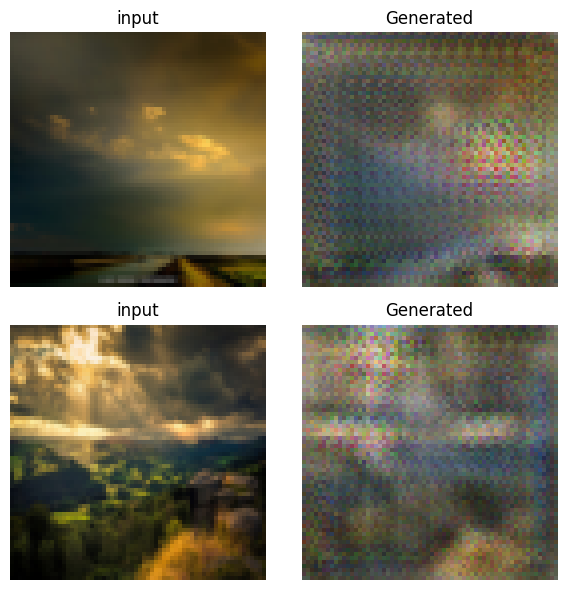

Epoch [1/100] | G Loss: 4.5053 | D_M: 0.229264035820961
Epoch [2/100] | G Loss: 4.6446 | D_M: 0.19861538708209991
Epoch [3/100] | G Loss: 4.6000 | D_M: 0.20817559957504272
Epoch [4/100] | G Loss: 3.6303 | D_M: 0.17269153892993927
Epoch [5/100] | G Loss: 3.5405 | D_M: 0.18275561928749084
Epoch [6/100] | G Loss: 3.5250 | D_M: 0.21043258905410767
Epoch [7/100] | G Loss: 3.7908 | D_M: 0.2230815291404724
Epoch [8/100] | G Loss: 3.6486 | D_M: 0.20421811938285828
Epoch [9/100] | G Loss: 3.4338 | D_M: 0.19282208383083344
Epoch [10/100] | G Loss: 3.4370 | D_M: 0.16391697525978088


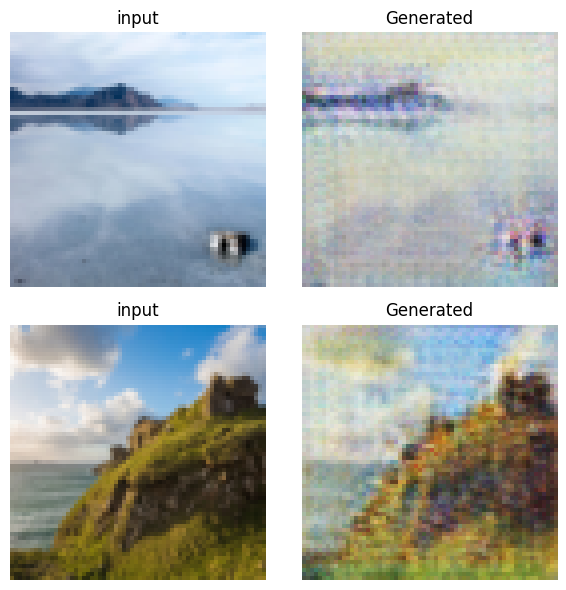

Epoch [11/100] | G Loss: 3.2916 | D_M: 0.22741377353668213
Epoch [12/100] | G Loss: 3.1094 | D_M: 0.19014638662338257
Epoch [13/100] | G Loss: 3.0802 | D_M: 0.2325839400291443
Epoch [14/100] | G Loss: 3.0890 | D_M: 0.22388261556625366
Epoch [15/100] | G Loss: 2.9876 | D_M: 0.20383915305137634
Epoch [16/100] | G Loss: 2.9355 | D_M: 0.14669343829154968
Epoch [17/100] | G Loss: 2.9466 | D_M: 0.17136436700820923
Epoch [18/100] | G Loss: 3.1060 | D_M: 0.17581509053707123
Epoch [19/100] | G Loss: 3.1497 | D_M: 0.18405789136886597
Epoch [20/100] | G Loss: 3.1847 | D_M: 0.18309617042541504


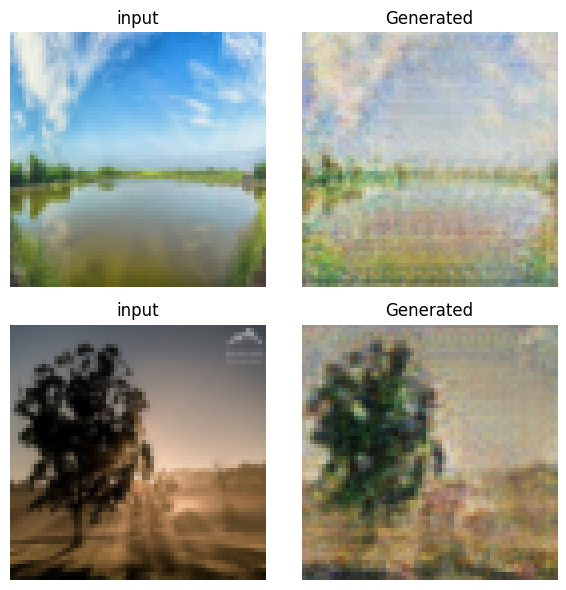

Epoch [21/100] | G Loss: 2.8872 | D_M: 0.17128679156303406
Epoch [22/100] | G Loss: 3.1092 | D_M: 0.14987464249134064
Epoch [23/100] | G Loss: 2.9699 | D_M: 0.1518438756465912
Epoch [24/100] | G Loss: 2.6748 | D_M: 0.17229756712913513
Epoch [25/100] | G Loss: 2.8808 | D_M: 0.236154705286026
Epoch [26/100] | G Loss: 2.6445 | D_M: 0.21668821573257446
Epoch [27/100] | G Loss: 2.5069 | D_M: 0.2154599279165268
Epoch [28/100] | G Loss: 2.5705 | D_M: 0.17833589017391205
Epoch [29/100] | G Loss: 2.9169 | D_M: 0.1758059561252594
Epoch [30/100] | G Loss: 2.7882 | D_M: 0.17418897151947021


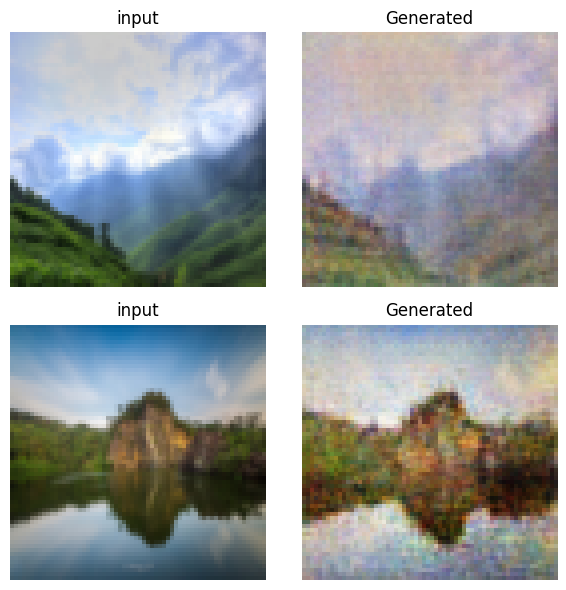

Epoch [31/100] | G Loss: 2.8883 | D_M: 0.15457892417907715
Epoch [32/100] | G Loss: 2.7078 | D_M: 0.16780118644237518
Epoch [33/100] | G Loss: 2.7311 | D_M: 0.16309744119644165
Epoch [34/100] | G Loss: 2.7113 | D_M: 0.15596313774585724
Epoch [35/100] | G Loss: 2.6363 | D_M: 0.1450977772474289
Epoch [36/100] | G Loss: 2.9266 | D_M: 0.16378074884414673
Epoch [37/100] | G Loss: 2.8193 | D_M: 0.14051887392997742
Epoch [38/100] | G Loss: 2.7284 | D_M: 0.17041707038879395
Epoch [39/100] | G Loss: 2.7015 | D_M: 0.1604008972644806
Epoch [40/100] | G Loss: 2.7766 | D_M: 0.15968865156173706


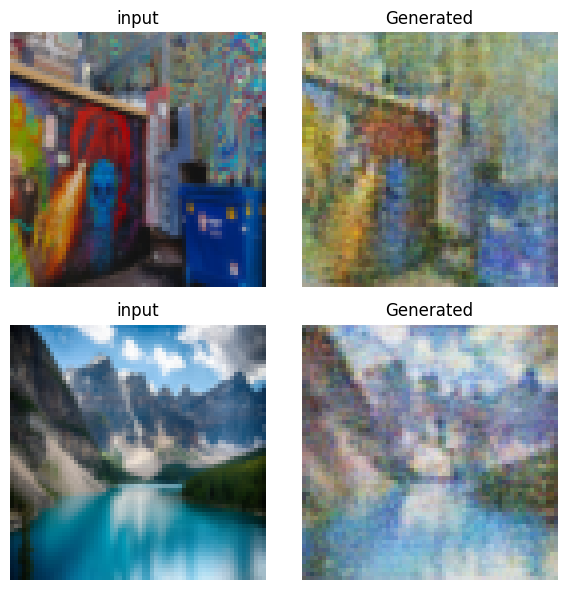

Epoch [41/100] | G Loss: 2.8724 | D_M: 0.14581024646759033
Epoch [42/100] | G Loss: 2.6000 | D_M: 0.15012748539447784
Epoch [43/100] | G Loss: 2.3877 | D_M: 0.18957582116127014
Epoch [44/100] | G Loss: 2.6174 | D_M: 0.14984428882598877
Epoch [45/100] | G Loss: 2.6939 | D_M: 0.15211957693099976
Epoch [46/100] | G Loss: 2.8089 | D_M: 0.14883649349212646
Epoch [47/100] | G Loss: 2.6010 | D_M: 0.1535661816596985
Epoch [48/100] | G Loss: 2.7330 | D_M: 0.14069563150405884
Epoch [49/100] | G Loss: 4.1649 | D_M: 0.2218431830406189
Epoch [50/100] | G Loss: 3.2205 | D_M: 0.22172033786773682


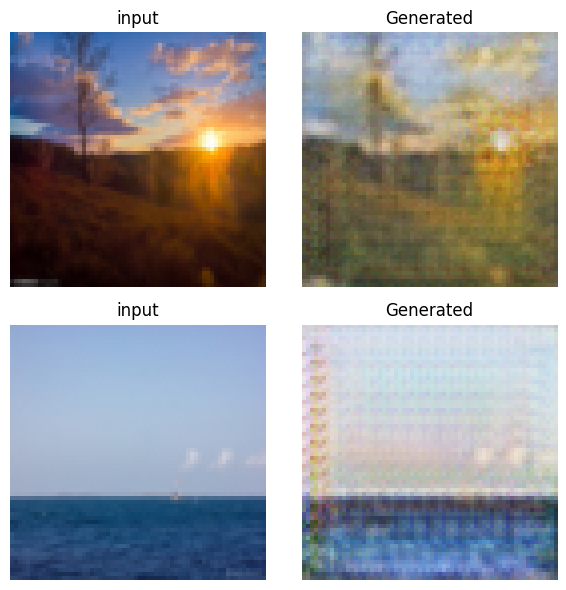

Epoch [51/100] | G Loss: 2.8579 | D_M: 0.21242910623550415
Epoch [52/100] | G Loss: 2.8928 | D_M: 0.21771270036697388
Epoch [53/100] | G Loss: 2.6924 | D_M: 0.19666408002376556
Epoch [54/100] | G Loss: 2.7939 | D_M: 0.18937663733959198
Epoch [55/100] | G Loss: 2.6300 | D_M: 0.172806978225708
Epoch [56/100] | G Loss: 2.8594 | D_M: 0.14278526604175568
Epoch [57/100] | G Loss: 2.8563 | D_M: 0.12546254694461823
Epoch [58/100] | G Loss: 2.8697 | D_M: 0.1066993921995163
Epoch [59/100] | G Loss: 2.8304 | D_M: 0.12445425987243652
Epoch [60/100] | G Loss: 2.9605 | D_M: 0.1093469113111496


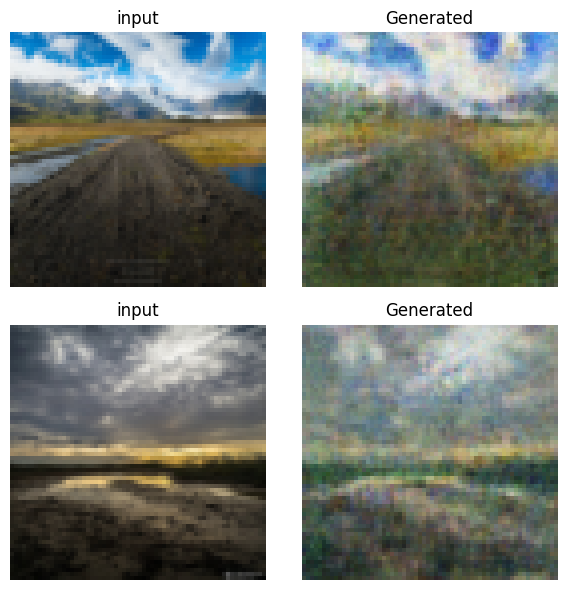

Epoch [61/100] | G Loss: 2.9628 | D_M: 0.11978554725646973
Epoch [62/100] | G Loss: 2.8944 | D_M: 0.11344752460718155
Epoch [63/100] | G Loss: 2.6804 | D_M: 0.11763401329517365
Epoch [64/100] | G Loss: 2.8388 | D_M: 0.12629270553588867
Epoch [65/100] | G Loss: 2.8012 | D_M: 0.11996753513813019
Epoch [66/100] | G Loss: 2.6933 | D_M: 0.12043628096580505
Epoch [67/100] | G Loss: 2.6269 | D_M: 0.1285044550895691
Epoch [68/100] | G Loss: 2.6975 | D_M: 0.14363497495651245
Epoch [69/100] | G Loss: 2.7927 | D_M: 0.122005894780159
Epoch [70/100] | G Loss: 2.7328 | D_M: 0.13168266415596008


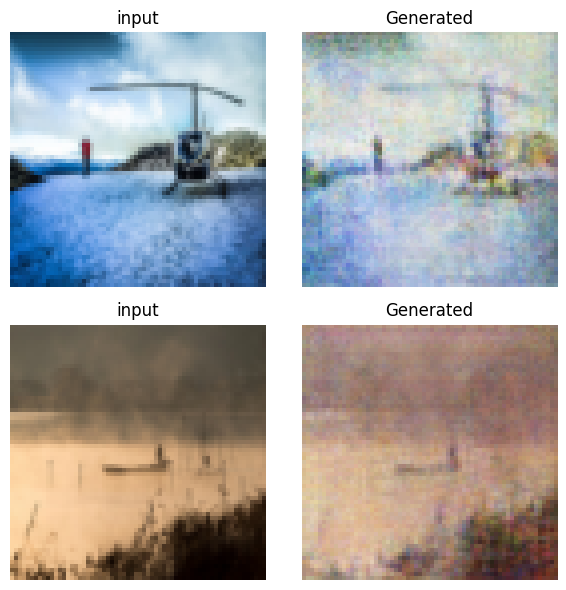

Epoch [71/100] | G Loss: 2.6114 | D_M: 0.1152493953704834
Epoch [72/100] | G Loss: 2.8029 | D_M: 0.1492321491241455
Epoch [73/100] | G Loss: 2.7239 | D_M: 0.12505050003528595
Epoch [74/100] | G Loss: 2.8547 | D_M: 0.12067139148712158
Epoch [75/100] | G Loss: 2.6761 | D_M: 0.13302786648273468
Epoch [76/100] | G Loss: 2.6920 | D_M: 0.14098629355430603
Epoch [77/100] | G Loss: 2.8834 | D_M: 0.14570274949073792
Epoch [78/100] | G Loss: 2.5831 | D_M: 0.12925894558429718
Epoch [79/100] | G Loss: 2.6480 | D_M: 0.13673755526542664
Epoch [80/100] | G Loss: 2.7767 | D_M: 0.14797064661979675


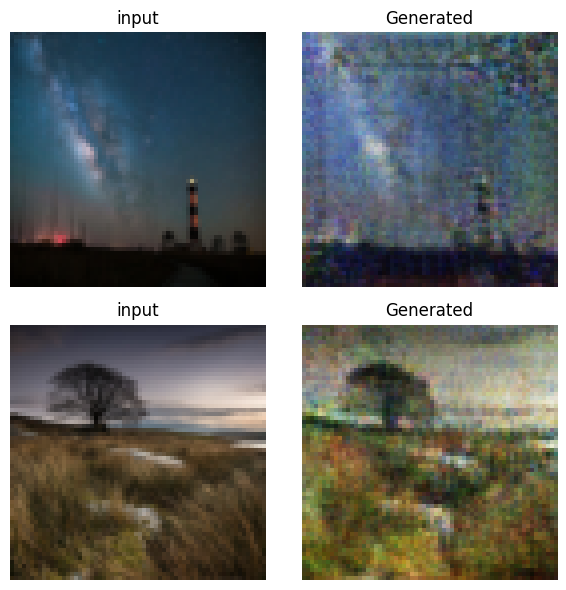

Epoch [81/100] | G Loss: 2.5191 | D_M: 0.1486331969499588
Epoch [82/100] | G Loss: 2.7110 | D_M: 0.1330101042985916
Epoch [83/100] | G Loss: 2.5972 | D_M: 0.13722002506256104
Epoch [84/100] | G Loss: 2.6256 | D_M: 0.1363990604877472
Epoch [85/100] | G Loss: 2.6521 | D_M: 0.17955642938613892
Epoch [86/100] | G Loss: 2.5091 | D_M: 0.1261318325996399
Epoch [87/100] | G Loss: 4.9311 | D_M: 0.338245153427124
Epoch [88/100] | G Loss: 3.2479 | D_M: 0.3030868470668793
Epoch [89/100] | G Loss: 3.1207 | D_M: 0.24723827838897705
Epoch [90/100] | G Loss: 2.9395 | D_M: 0.2546270489692688


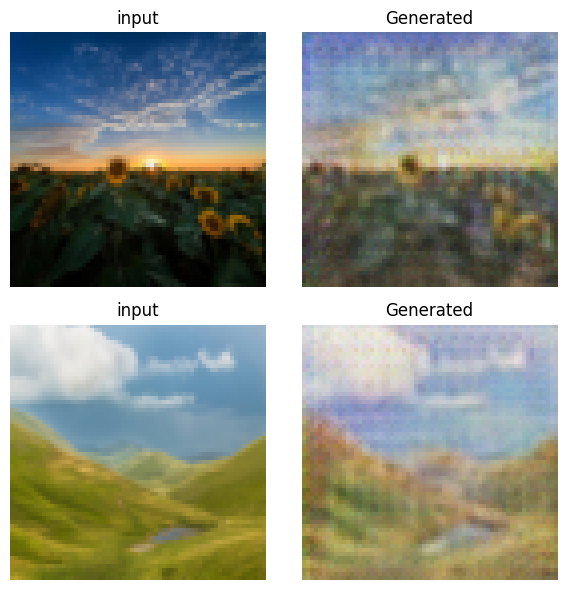

Epoch [91/100] | G Loss: 2.7007 | D_M: 0.2410597801208496
Epoch [92/100] | G Loss: 2.4759 | D_M: 0.22933518886566162
Epoch [93/100] | G Loss: 2.4829 | D_M: 0.22543808817863464
Epoch [94/100] | G Loss: 2.5904 | D_M: 0.22515222430229187
Epoch [95/100] | G Loss: 2.5436 | D_M: 0.2042112946510315
Epoch [96/100] | G Loss: 2.5776 | D_M: 0.19565409421920776
Epoch [97/100] | G Loss: 2.7284 | D_M: 0.1882190704345703
Epoch [98/100] | G Loss: 2.6911 | D_M: 0.18082737922668457
Epoch [99/100] | G Loss: 2.4606 | D_M: 0.17345088720321655
Epoch [100/100] | G Loss: 2.6152 | D_M: 0.11859476566314697


In [6]:
num_epochs = 100
lambda_cycle = 10 
device = "cuda" if torch.cuda.is_available() else "cpu"

for epoch in range(num_epochs):
    for i, (real_M, real_R) in enumerate(train_loader):
        
        real_M = real_M.to(device)
        real_R = real_R.to(device)

        ### Train Generator ###
        g_optimizer.zero_grad()

        # GAN loss
        fake_R = G_M2R(real_M)
        fake_M = G_R2M(real_R)
        loss_gan_M2R = adversarial_loss(D_R(fake_R), torch.ones_like(D_R(fake_R)))
        loss_gan_R2M = adversarial_loss(D_M(fake_M), torch.ones_like(D_M(fake_M)))

        # Cycle loss
        rec_M = G_R2M(fake_R)
        rec_R = G_M2R(fake_M)
        loss_cycle = cycle_loss(rec_M, real_M) + cycle_loss(rec_R, real_R)

        # Total generator loss
        g_loss = loss_gan_M2R + loss_gan_R2M + lambda_cycle*loss_cycle
        g_loss.backward()
        g_optimizer.step()

        ### Train Discriminator ###
        # D_M
        d_optimizer_M.zero_grad()
        loss_D_M = (adversarial_loss(D_M(real_M), torch.ones_like(D_M(real_M))) +
                    adversarial_loss(D_M(fake_M.detach()), torch.zeros_like(D_M(fake_M)))) / 2
        loss_D_M.backward()
        d_optimizer_M.step()

        # D_R
        d_optimizer_R.zero_grad()
        loss_D_R = (adversarial_loss(D_R(real_R), torch.ones_like(D_R(real_R))) +
                    adversarial_loss(D_R(fake_R.detach()), torch.zeros_like(D_R(fake_R)))) / 2
        loss_D_R.backward()
        d_optimizer_R.step()

    if epoch % 10 == 0:
        save_sample_images(epoch, G_R2M, test_loader, device)

    print(f"Epoch [{epoch+1}/{num_epochs}] | G Loss: {g_loss.item():.4f} | D_M: {loss_D_M.item()}")
    